## Import Libraries


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

## Import and Merge Data Files

In [2]:
# We have here 12 months of data for a Bike-Share company from 4/1/2024 to 3/31/2025
# The code below is to append 12 monthly CSV files into a single file

# Path to the folder containing the files
folder_path = r'C:\Users\Ayman\Desktop\Data Analysis\Courses\Google Data Analytics Professional Certificate\Case Study\Dataset\Data'

# List all files in the folder and sort them based on name
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
csv_files.sort() 

# Read and append all files
df_bike_share = pd.concat([pd.read_csv(os.path.join(folder_path, file)) for file in csv_files], ignore_index=True)

# Save the appended file 
df_bike_share.to_csv(r'C:\Users\Ayman\Desktop\Data Analysis\Courses\Google Data Analytics Professional Certificate\Case Study\Dataset\Combined_Data.csv', index=False)

df_bike_share.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,743252713F32516B,classic_bike,2024-04-22 19:08:21,2024-04-22 19:12:56,Aberdeen St & Jackson Blvd,13157,Desplaines St & Jackson Blvd,15539,41.877726,-87.654787,41.878119,-87.643948,member
1,BE90D33D2240C614,electric_bike,2024-04-11 06:19:24,2024-04-11 06:22:21,Aberdeen St & Jackson Blvd,13157,Desplaines St & Jackson Blvd,15539,41.877722,-87.654959,41.878119,-87.643948,member
2,D47BBDDE7C40DD61,classic_bike,2024-04-20 11:13:13,2024-04-20 11:29:31,Sheridan Rd & Montrose Ave,TA1307000107,Ashland Ave & Belle Plaine Ave,13249,41.961670,-87.654640,41.956057,-87.668835,member
3,6684E760BF9EA9B5,classic_bike,2024-04-04 18:39:20,2024-04-04 18:43:06,Aberdeen St & Jackson Blvd,13157,Desplaines St & Jackson Blvd,15539,41.877726,-87.654787,41.878119,-87.643948,member
4,CA9EFC0D24C24A27,electric_bike,2024-04-19 19:30:20,2024-04-19 20:07:42,Sheridan Rd & Montrose Ave,TA1307000107,Stetson Ave & South Water St,TA1308000029,41.961613,-87.654615,41.886835,-87.622320,member


## Cleaning the Data

In [3]:
# Remove station names, ids, latitude, and longitude columns from the dataset
columns_to_drop = ['start_station_name', 'start_station_id', 'end_station_name', 
                  'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng']

df_bike_share = df_bike_share.drop(columns=columns_to_drop)

In [4]:
# Count the number of duplicated values in the 'ride_id' column
duplicate_count = df_bike_share['ride_id'].duplicated().sum()
print(f"Number of duplicate ride_id values: {duplicate_count}")

Number of duplicate ride_id values: 211


In [5]:
# Remove the duplicated values from 'ride_id' column
df_bike_share = df_bike_share.drop_duplicates(subset='ride_id', keep='first')
print(f"Number of duplicate ride_id values: {df_bike_share['ride_id'].duplicated().sum()}")

Number of duplicate ride_id values: 0


In [6]:
# Checking the null values
print(df_bike_share.isnull().sum())

ride_id          0
rideable_type    0
started_at       0
ended_at         0
member_casual    0
dtype: int64


In [7]:
# Convert to datetime
df_bike_share['started_at'] = pd.to_datetime(df_bike_share['started_at'], format='ISO8601')
df_bike_share['ended_at'] = pd.to_datetime(df_bike_share['ended_at'], format='ISO8601')

# Calculate duration in minutes (handles multi-day properly)
df_bike_share['ride_duration_min'] = (
    (df_bike_share['ended_at'] - df_bike_share['started_at'])
    .dt.total_seconds() / 60  # Convert to minutes
).astype(int)

# Find ride duration > 24 hours (1440 minutes)
multi_day_rides = df_bike_share[df_bike_share['ride_duration_min'] > 1440]

# Remove ride duration > 24 hours
df_bike_share = df_bike_share[df_bike_share['ride_duration_min'] <= 1440]  
 
print(f"Found {len(multi_day_rides)} rides lasting more than 24 hours, and removed\n")
print(multi_day_rides[['started_at', 'ended_at', 'ride_duration_min']].head())
print("\n")
print(df_bike_share.head())

Found 6819 rides lasting more than 24 hours, and removed

               started_at            ended_at  ride_duration_min
3598  2024-04-09 18:41:23 2024-04-10 19:34:56               1493
11856 2024-04-20 17:22:36 2024-04-21 18:06:03               1483
59753 2024-04-21 16:48:17 2024-04-22 16:51:22               1443
61009 2024-04-04 12:17:23 2024-04-05 13:17:17               1499
61027 2024-04-30 23:59:46 2024-05-02 00:59:33               1499


            ride_id  rideable_type          started_at            ended_at  \
0  743252713F32516B   classic_bike 2024-04-22 19:08:21 2024-04-22 19:12:56   
1  BE90D33D2240C614  electric_bike 2024-04-11 06:19:24 2024-04-11 06:22:21   
2  D47BBDDE7C40DD61   classic_bike 2024-04-20 11:13:13 2024-04-20 11:29:31   
3  6684E760BF9EA9B5   classic_bike 2024-04-04 18:39:20 2024-04-04 18:43:06   
4  CA9EFC0D24C24A27  electric_bike 2024-04-19 19:30:20 2024-04-19 20:07:42   

  member_casual  ride_duration_min  
0        member                  4  
1      

In [8]:
# Filter rows where ride duration is negative; 'end_time' is less than 'start_time' within the same day
negative_rides = df_bike_share[df_bike_share['ride_duration_min'] < 0]
df_bike_share = df_bike_share[df_bike_share['ride_duration_min'] > 0].copy()

print(f"Found {len(negative_rides)} rides with negative duration values, and filtered out\n")
print(negative_rides[['started_at', 'ended_at', 'ride_duration_min']].head())

Found 81 rides with negative duration values, and filtered out

                started_at            ended_at  ride_duration_min
258872 2024-04-07 13:03:39 2024-04-07 12:00:09                -63
270042 2024-04-08 19:07:25 2024-04-08 18:05:21                -62
271969 2024-04-17 11:10:03 2024-04-17 10:07:43                -62
277439 2024-04-04 21:14:34 2024-04-04 18:34:32               -160
281317 2024-04-08 11:35:48 2024-04-08 10:28:17                -67


In [9]:
# Separate the date-time columns 'started_at' and 'ended_at' into date and time columns

# Extract date columns 'start_date' and 'end_date'
df_bike_share['start_date'] = df_bike_share['started_at'].dt.date
df_bike_share['end_date'] = df_bike_share['ended_at'].dt.date

# Extract time columns 'start_time' and 'end_time'
df_bike_share['start_time'] = df_bike_share['started_at'].dt.time
df_bike_share['end_time'] = df_bike_share['ended_at'].dt.time

# Drop original columns 'started_at' and 'ended_at'
df_bike_share = df_bike_share.drop(['started_at', 'ended_at'], axis=1)

print(df_bike_share.head())


            ride_id  rideable_type member_casual  ride_duration_min  \
0  743252713F32516B   classic_bike        member                  4   
1  BE90D33D2240C614  electric_bike        member                  2   
2  D47BBDDE7C40DD61   classic_bike        member                 16   
3  6684E760BF9EA9B5   classic_bike        member                  3   
4  CA9EFC0D24C24A27  electric_bike        member                 37   

   start_date    end_date start_time  end_time  
0  2024-04-22  2024-04-22   19:08:21  19:12:56  
1  2024-04-11  2024-04-11   06:19:24  06:22:21  
2  2024-04-20  2024-04-20   11:13:13  11:29:31  
3  2024-04-04  2024-04-04   18:39:20  18:43:06  
4  2024-04-19  2024-04-19   19:30:20  20:07:42  


In [10]:
# Convert to datetime (handling any format issues)
df_bike_share['start_date'] = pd.to_datetime(df_bike_share['start_date'], errors='coerce')
df_bike_share['end_date'] = pd.to_datetime(df_bike_share['end_date'], errors='coerce')

# Create day name column (first 3 letters)
df_bike_share['day_name'] = df_bike_share['start_date'].dt.day_name().str[:3]

# Create numeric day column 
df_bike_share['day_num'] = df_bike_share['start_date'].dt.dayofweek + 1  # +1 to start at 1

# Fix the numbering to match (Sunday=1, Saturday=7)
df_bike_share['day_num'] = df_bike_share['start_date'].dt.dayofweek.replace({
    0: 2,  # Monday → 2
    1: 3,  # Tuesday → 3
    2: 4,  # Wednesday → 4
    3: 5,  # Thursday → 5
    4: 6,  # Friday → 6
    5: 7,  # Saturday → 7
    6: 1   # Sunday → 1
})

# Create month name column (first 3 letters)
df_bike_share['month_name'] = df_bike_share['start_date'].dt.month_name().str[:3]

# Create month number column (1-12)
df_bike_share['month_num'] = df_bike_share['start_date'].dt.month

# Create quarter column (1-4)
df_bike_share['quarter'] = df_bike_share['start_date'].dt.quarter

# Create a column for day's time periods
def get_day_part(time_obj):
    hour = time_obj.hour
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'  # Includes late night and early morning

df_bike_share['time_period'] = df_bike_share['start_time'].apply(get_day_part)

print(df_bike_share.head())

            ride_id  rideable_type member_casual  ride_duration_min  \
0  743252713F32516B   classic_bike        member                  4   
1  BE90D33D2240C614  electric_bike        member                  2   
2  D47BBDDE7C40DD61   classic_bike        member                 16   
3  6684E760BF9EA9B5   classic_bike        member                  3   
4  CA9EFC0D24C24A27  electric_bike        member                 37   

  start_date   end_date start_time  end_time day_name  day_num month_name  \
0 2024-04-22 2024-04-22   19:08:21  19:12:56      Mon        2        Apr   
1 2024-04-11 2024-04-11   06:19:24  06:22:21      Thu        5        Apr   
2 2024-04-20 2024-04-20   11:13:13  11:29:31      Sat        7        Apr   
3 2024-04-04 2024-04-04   18:39:20  18:43:06      Thu        5        Apr   
4 2024-04-19 2024-04-19   19:30:20  20:07:42      Fri        6        Apr   

   month_num  quarter time_period  
0          4        2     Evening  
1          4        2     Morning  
2 

# Exploratory Data Analysis

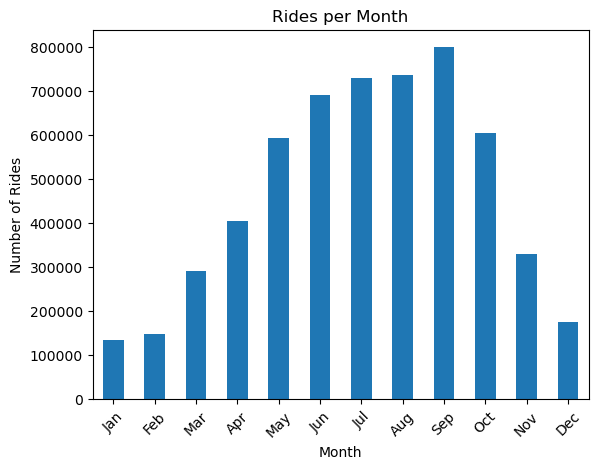

In [11]:
# Data distribution by month

# Group by month_num, then label x-axis with names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df_bike_share.groupby('month_num')['ride_id'].count().plot(
    kind='bar',
    title='Rides per Month',
    xlabel='Month',
    ylabel='Number of Rides'
)
plt.xticks(range(12), month_names, rotation=45)
plt.show()

<Axes: >

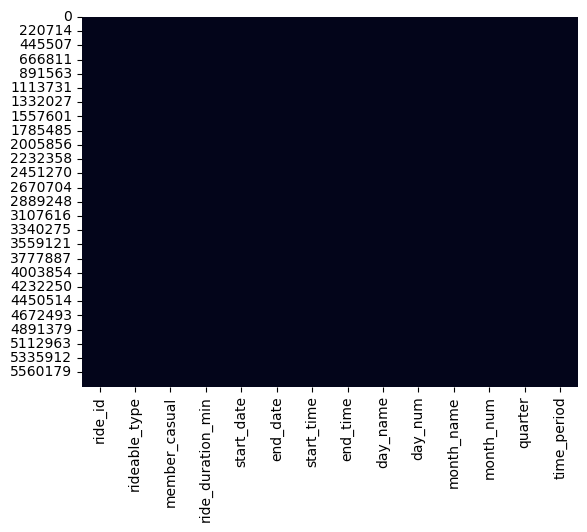

In [12]:
# Null values heatmap
sns.heatmap(df_bike_share.isnull(), cbar=False)

<Axes: xlabel='member_casual', ylabel='ride_duration_min'>

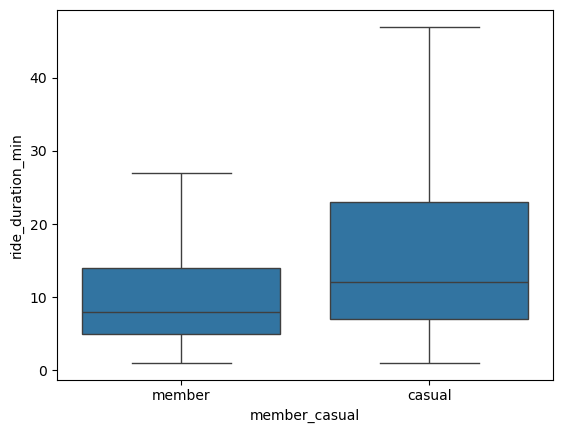

In [13]:
# Distribution of ride durations by user type
sns.boxplot(x='member_casual', y='ride_duration_min', data=df_bike_share, showfliers=False)

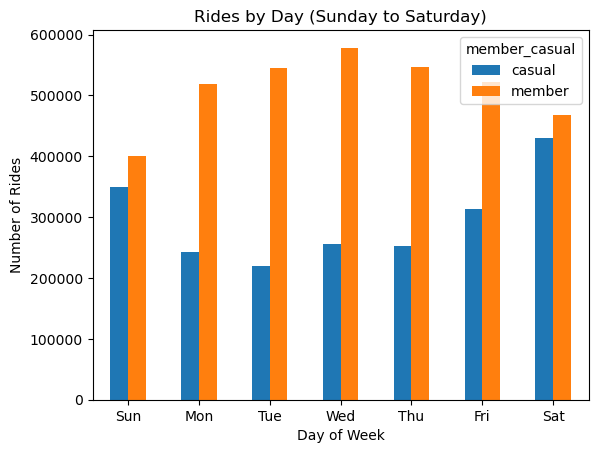

In [14]:
# Rides by day of week for user type
day_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

df_bike_share.groupby(['day_num', 'member_casual']).size().unstack().sort_index().plot(
    kind='bar',
    stacked=False,
    title='Rides by Day (Sunday to Saturday)',
    xlabel='Day of Week',
    ylabel='Number of Rides'
)
plt.xticks(range(7), day_names, rotation=360)  # Map numbers to day names
plt.show()

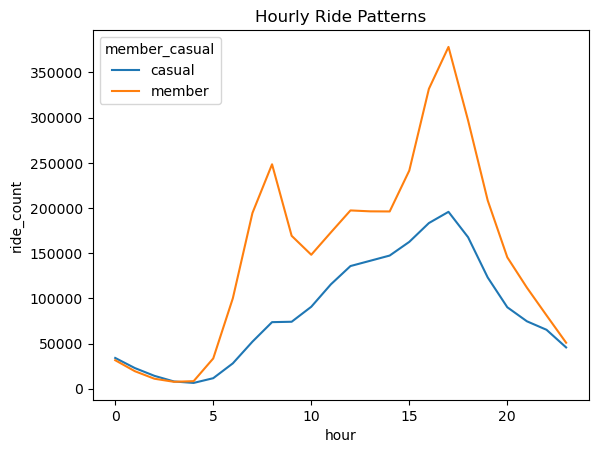

In [15]:
# Hourly usage patterns by user type

# Extract hour from time objects
df_bike_share['hour'] = df_bike_share['start_time'].apply(lambda x: x.hour)

# Plotting
hourly_counts = df_bike_share.groupby(['hour', 'member_casual']).size().reset_index(name='ride_count')
sns.lineplot(x='hour', y='ride_count', hue='member_casual', data=hourly_counts)
plt.title('Hourly Ride Patterns')
plt.show()

<Axes: xlabel='time_period'>

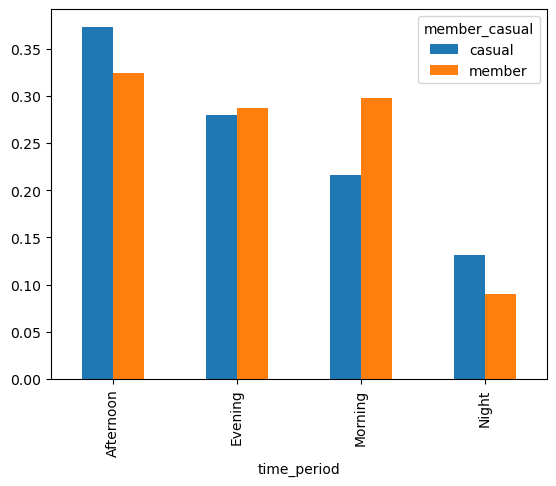

In [16]:
# Rides by time periods by user type
pd.crosstab(df_bike_share['time_period'], df_bike_share['member_casual'], normalize='columns').plot(kind='bar')

<Axes: title={'center': 'Monthly Rides: Members vs. Casual'}, xlabel='Month', ylabel='Number of Rides'>

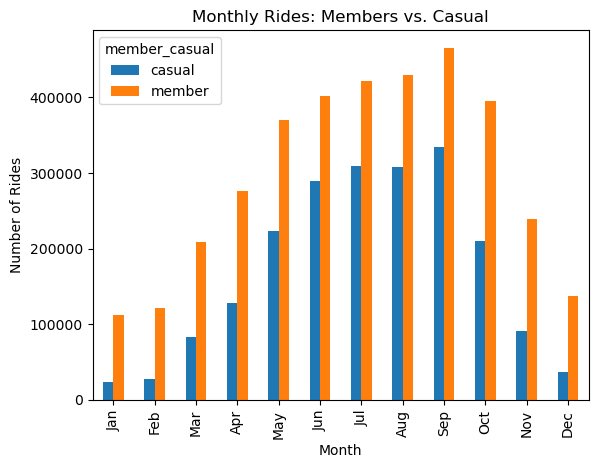

In [17]:
# Ride volume over time by user type
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df_bike_share.groupby(['month_name', 'member_casual']).size().unstack().loc[month_order].plot(
    kind='bar',
    title='Monthly Rides: Members vs. Casual',
    xlabel='Month',
    ylabel='Number of Rides'
)

In [18]:
df_bike_share.to_parquet('cyclistic_cleaned.parquet', engine='pyarrow', compression='snappy')

In [19]:
# Read Parquet and sample 1,000 random rows
df_sample = pd.read_parquet('cyclistic_cleaned.parquet').sample(n=1000, random_state=42)

# Save as CSV
df_sample.to_csv('sample_data.csv', index=False)